In [3]:
import numpy as np
import pandas as pd
import yaml
import torch
from torch import nn
import scanpy as sc
import scvelo as scv

from torch.utils.data import DataLoader
import pytorch_lightning as pl

import torch.nn.functional as F

from scvi.distributions import NegativeBinomial
from celldreamer.data.scrnaseq_loader import RNAseqLoader
from celldreamer.models.featurizers.category_featurizer import CategoricalFeaturizer
from celldreamer.eval.optimal_transport import wasserstein

from celldreamer.models.base.utils import unsqueeze_right
import matplotlib.pyplot as plt

device  = "cuda" if torch.cuda.is_available() else "cpu"

**Util function**

**Cofigurations**

In [26]:
dataset_config = {'dataset_path': '/home/icb/alessandro.palma/environment/celldreamer/datasets/processed/dentategyrus.h5ad',
                    'layer_key': 'X_counts',
                    'covariate_keys': ['clusters'],
                    'sampling_covariate': 'clusters',
                    'subsample_frac': 1,
                    'encoder_type': 'log_gexp',
                    'target_max': 1,
                    'target_min': -1,
                    'n_dimensions': None,
                    'one_hot_encode_features': True,
                    'split_rates': [0.90, 0.05, 0.05],
                    'cov_embedding_dimensions': None}

In [27]:
# ckpt = torch.load("/home/icb/alessandro.palma/environment/celldreamer/project_folder/celldreamer/02ed0f92-c9b1-44a1-ada8-4f3fdc2f3594/checkpoints/last.ckpt")

In [28]:
# ckpt["state_dict"]["theta"].max()

**Initialization**

Initialize dataset 

In [29]:
data_path = dataset_config["dataset_path"]

dataset = RNAseqLoader(data_path=data_path,
                                layer_key=dataset_config["layer_key"],
                                covariate_keys=dataset_config["covariate_keys"],
                                subsample_frac=dataset_config["subsample_frac"], 
                                encoder_type=dataset_config["encoder_type"],
                                target_max=dataset_config["target_max"], 
                                target_min=dataset_config["target_min"])

in_dim = dataset.X.shape[1]
size_factor_statistics = {"mean": dataset.log_size_factor_mu, 
                                  "sd": dataset.log_size_factor_sd}

Initialize feature embeddings

In [30]:
# class Encoder(pl.LightningModule):
#     def __init__(self, lr, wd):
#         super().__init__()  
#         self.lr = lr
#         self.wd = wd
#         self.theta_preexp = torch.nn.Parameter(torch.randn(11, 2000), requires_grad=True)
#         self.model = nn.Sequential(
#             nn.Linear(2000, 512),
#             nn.BatchNorm1d(512),  # Batch Normalization
#             nn.SELU(),
#             nn.Linear(512, 512), #try skip connections
#             nn.BatchNorm1d(512),  # Batch Normalization
#             nn.SELU(),
#             nn.Linear(512, 2000))

#     def forward(self, x, y):
#         roh_presoftmax = self.model(x) #parameters of a negative binamial distribution
#         theta = torch.exp(self.theta_preexp[y])
#         return roh_presoftmax, theta
    
#     def training_step(self, batch, batch_idx):
#         X = batch['X']
#         l = X.sum(1).unsqueeze(1)
#         y = batch["y"]["y_celltype"]
#         X_log = dataset.scaler.scale(batch["X_norm"].cuda())

#         roh_presoftmax, theta = self.forward(X_log, y)
#         roh = F.softmax(roh_presoftmax, dim=1)

#         #see scvi tools
#         px = NegativeBinomial(mu=l*roh, theta=theta)
#         loss = - px.log_prob(X).sum(1).mean()#counts

#         self.log('train_loss', loss, on_epoch=True, prog_bar=True)
#         return loss

#     def configure_optimizers(self):
#         return torch.optim.Adam(self.parameters(), lr=self.lr)

# # Instantiate the Encoder model
# encoder_model = Encoder(lr=0.0001, wd=1e-2).cuda()

# dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# # Instantiate a Lightning Trainer
# trainer = pl.Trainer(max_epochs=200)  # You can adjust max_epochs and gpus as needed

# # Train the model
# trainer.fit(encoder_model, dataloader)

In [63]:
class Encoder(pl.LightningModule):
    def __init__(self, lr, wd):
        super().__init__()  
        self.lr = lr
        self.wd = wd
        self.theta_preexp = torch.nn.Parameter(torch.randn(2000), requires_grad=True)
        self.model = nn.Sequential(
            nn.Linear(2000, 512),
            nn.BatchNorm1d(512),  # Batch Normalization
            nn.SELU(),
            nn.Linear(512, 512), #try skip connections
            nn.BatchNorm1d(512),  # Batch Normalization
            nn.SELU(),
            nn.Linear(512, 2000))

    def forward(self, x):
        roh_presoftmax = self.model(x) #parameters of a negative binamial distribution
        theta = torch.exp(self.theta_preexp)
        return roh_presoftmax, theta
    
    def training_step(self, batch, batch_idx):
        X = batch['X']
        l = X.sum(1).unsqueeze(1)
        X_log = dataset.scaler.scale(batch["X_norm"].cuda())

        roh_presoftmax, theta = self.forward(X_log)
        roh = F.softmax(roh_presoftmax, dim=1)

        #see scvi tools
        px = NegativeBinomial(mu=l*roh, theta=theta)
        loss = - px.log_prob(X).sum(1).mean()#counts

        self.log('train_loss', loss, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.wd)

# Instantiate the Encoder model
encoder_model = Encoder(lr=0.001, wd=1e-2).cuda()

dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

# Instantiate a Lightning Trainer
trainer = pl.Trainer(max_epochs=200, gradient_clip_val=1)  # You can adjust max_epochs and gpus as needed

# Train the model
trainer.fit(encoder_model, dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type       | Params
--------------------------------------------
0 | model        | Sequential | 2.3 M 
  | other params | n/a        | 2.0 K 
--------------------------------------------
2.3 M     Trainable params
0         Non-trainable params
2.3 M     Total params
9.269     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

In [36]:
encoder_model.to("cuda")

Encoder(
  (model): Sequential(
    (0): Linear(in_features=2000, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SELU()
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): SELU()
    (6): Linear(in_features=512, out_features=2000, bias=True)
  )
)

In [289]:
# Z_enc = []
# X_real = []
# X_generated = []

# with torch.no_grad():
#     for batch in dataloader:
#         # Logarithm of X
#         l = batch["X"].sum(1).unsqueeze(1).cuda()
#         y = batch["y"]["y_celltype"]
#         X_log = dataset.scaler.scale(batch["X_norm"].cuda())
#         Z, _ = encoder_model(X_log, y)
#         Z_enc.append(Z.cpu())
#         X_real.append(batch["X"].cpu())
#         # Sample 
#         distr = NegativeBinomial(mu=torch.softmax(Z, 1)*l, theta=torch.exp(encoder_model.theta_preexp[y]))
#         X_sample = distr.sample()
#         X_generated.append(X_sample.cpu())

# Z_enc = torch.cat(Z_enc, dim=0)
# X_real = torch.cat(X_real, dim=0)
# X_generated = torch.cat(X_generated, dim=0)

In [37]:
Z_enc = []
X_real = []
X_generated = []

with torch.no_grad():
    for batch in dataloader:
        # Logarithm of X
        l = batch["X"].sum(1).unsqueeze(1).cuda()
        y = batch["y"]["clusters"]
        X_log = dataset.scaler.scale(batch["X_norm"].cuda())
        Z, _ = encoder_model(X_log)
        Z_enc.append(Z.cpu())
        X_real.append(batch["X"].cpu())
        # Sample 
        distr = NegativeBinomial(mu=torch.softmax(Z, 1)*l, theta=torch.exp(encoder_model.theta_preexp))
        X_sample = distr.sample()
        X_generated.append(X_sample.cpu())

Z_enc = torch.cat(Z_enc, dim=0)
X_real = torch.cat(X_real, dim=0)
X_generated = torch.cat(X_generated, dim=0)

In [38]:
Z_enc.min()

tensor(-28.3125)

In [39]:
adata_z = sc.AnnData(X=Z_enc.numpy())
obs = pd.DataFrame(["real" for _ in range(len(X_real))]+["generated" for _ in range(len(X_generated))])
obs.columns = ["dataset_type"]
adata = sc.AnnData(torch.cat([X_real, X_generated], dim=0).numpy(),
                  obs=obs)

In [40]:
for batch in dataloader:
    scaled = dataset.scaler.scale(batch["X_norm"].cuda())
    # scaled = batch["X_norm"]
    break

**Check embeddings**

In [41]:
sc.tl.pca(adata_z)
sc.pp.neighbors(adata_z)
sc.tl.umap(adata_z)

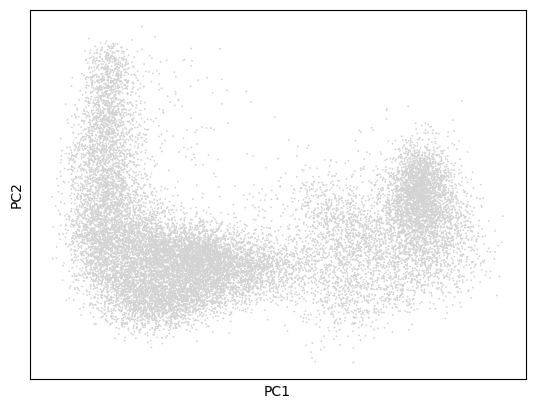

In [42]:
sc.pl.pca(adata_z)

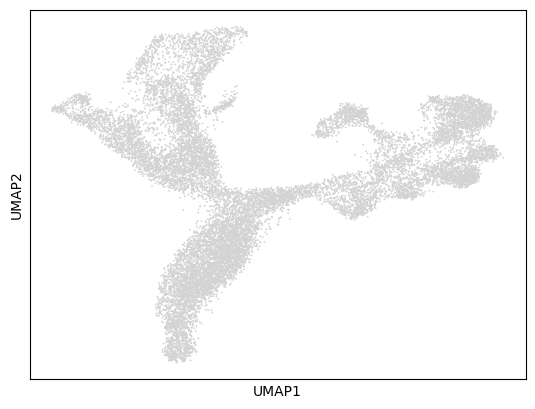

In [43]:
sc.pl.umap(adata_z)

**Real versus generated**

In [44]:
sc.pp.log1p(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

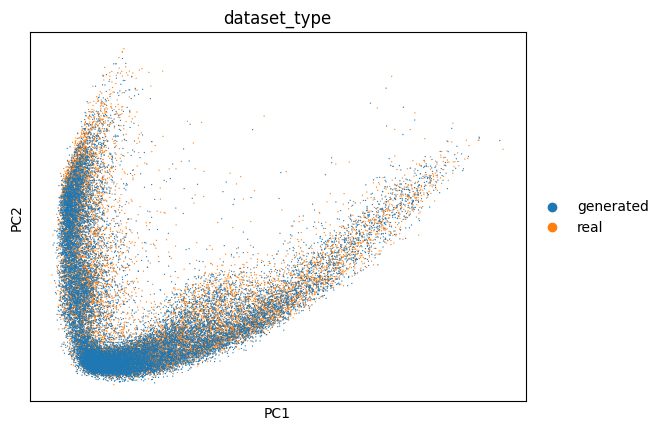

In [45]:
sc.pl.pca(adata, color="dataset_type")

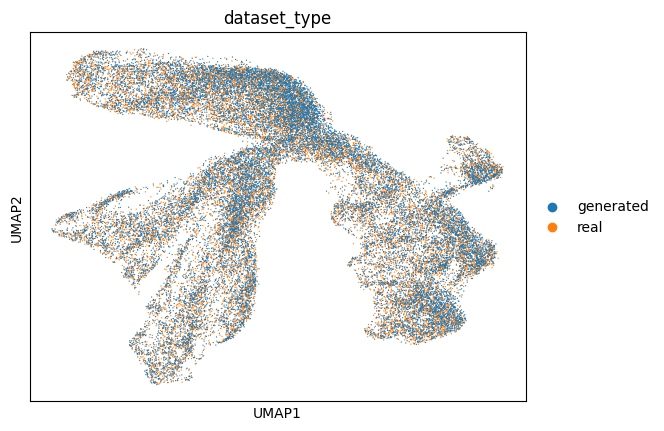

In [46]:
sc.pl.umap(adata, color="dataset_type")

In [62]:
Z_enc[:,1500]

tensor([-12.2596,  -8.6512,  -4.5605,  ...,  -9.8146,  -7.1842,  -4.5976])

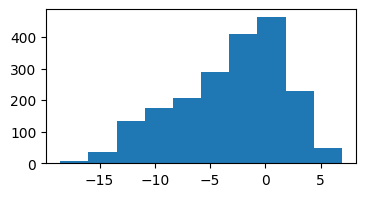

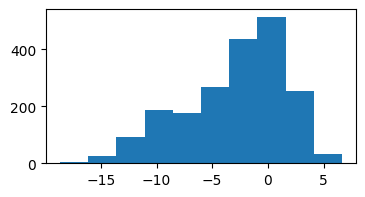

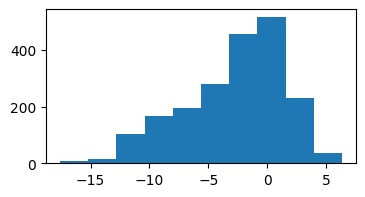

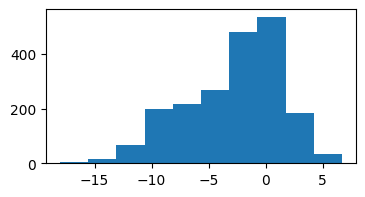

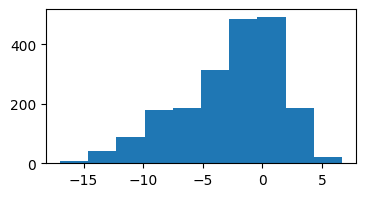

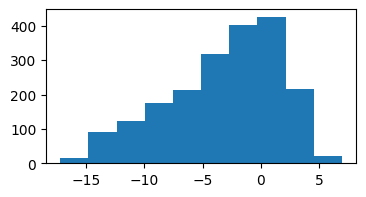

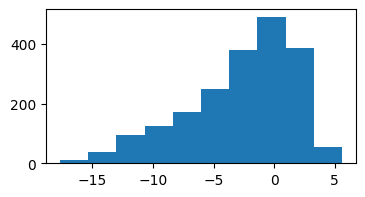

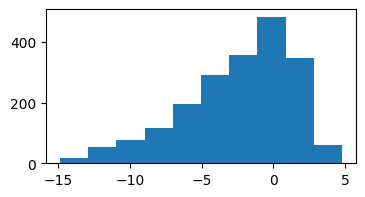

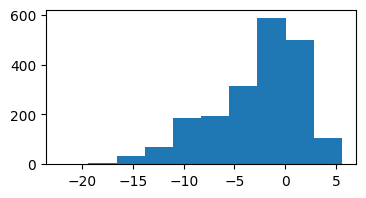

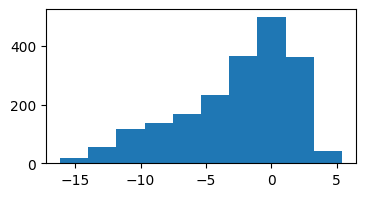

In [47]:
for i in range(10):
    plt.figure(figsize=(4,2))
    plt.hist(Z_enc[i].ravel())
    plt.show()

In [48]:
adata = sc.read_h5ad("/home/icb/alessandro.palma/environment/celldreamer/datasets/processed/pbmc68k.h5ad")

In [49]:
adata.layers["X_counts"].sum(1)

matrix([[20.],
        [15.],
        [15.],
        ...,
        [19.],
        [12.],
        [10.]], dtype=float32)

In [50]:
adata.layers["X_counts"].A.max(1).max()

47.0

In [51]:
adata.obs["size_factor"] = adata.layers["X_counts"].sum(1)

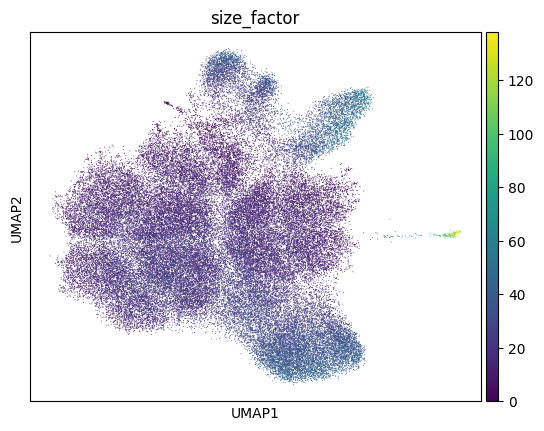

In [52]:
sc.pl.umap(adata, color="size_factor")

In [308]:
len(np.unique(adata.obs.celltype))

11